In [1]:
# include packages and libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams # detailed parameter setting
""" more details on customization: https://matplotlib.org/stable/tutorials/introductory/customizing.html """
from typing import Dict, List, Union
import numpy as np
from scipy.stats import norm

# HW 2/1
Smart up our plotter to be able to customize the hard-coded layout setup inside the function. Add more custom feature that you would like to use.

In [2]:
# smarter plotter
def my_smarter_plotter(x: List[float], y: Union[List[float], List[List[float]]], layout: Dict = {}, names: List[str] = None):
    
    y = [y] if all(isinstance(item, float) for item in y) else y
    
    # layout options with defaults
    figsize = layout.get("figsize", (8, 4))
    background_color = layout.get("background_color", "white")
    grid = layout.get("grid", False)
    grid_style = layout.get("grid_style", {"color": "gray", "linestyle": "--", "linewidth": 0.5})
    x_lim = layout.get("x_lim", None)
    y_lim = layout.get("y_lim", None)
    line_style = layout.get("line_style", "solid")
    line_width = layout.get("line_width", 4)
    line_colors = layout.get("line_color", None)
    legend_loc = layout.get("legend_loc", "best")
    legend_fontsize = layout.get("legend_size", 16)
    title_fontsize = layout.get("title_fontsize", 30)
    axis_label_fontsize = layout.get("axis_label_fontsize", 16)
    
    plt.figure(figsize = figsize, facecolor = background_color)
    lines = []
    show_legend = names is not None
    
    if show_legend and len(names) != len(y):
        raise ValueError("Length of names does not match number of plotted y lists.")
    
    for i, y_item in enumerate(y):
        plot_kwargs = {
            'linestyle': line_style,
            'linewidth': line_width,
            'color': line_colors[i] if line_colors and i < len(line_colors) else None,
            'label': names[i] if show_legend else None
        }
        _line = plt.plot(x, y_item, **{k: v for k, v in plot_kwargs.items() if v is not None})
        lines.append(_line)
    
    if show_legend:
        plt.legend(fontsize = legend_fontsize, loc = legend_loc)
    if 'title' in layout:
        plt.title(layout['title'], fontsize = title_fontsize)
        rcParams['axes.titlepad'] = 30
    if 'x_label' in layout:
        plt.xlabel(layout['x_label'], fontsize = axis_label_fontsize)
        rcParams['axes.labelpad'] = 20
    if 'y_label' in layout:
        plt.ylabel(layout['y_label'], fontsize = axis_label_fontsize)
    
    # apply x and y limits if provided
    if x_lim:
        plt.xlim(x_lim)
    if y_lim:
        plt.ylim(y_lim)
    
    # enable grid if requested
    if grid:
        plt.grid(**grid_style)
    
    ax = plt.gca()
    ax.axhline(linestyle = '--', color = 'black', linewidth = 1)
    plt.show()

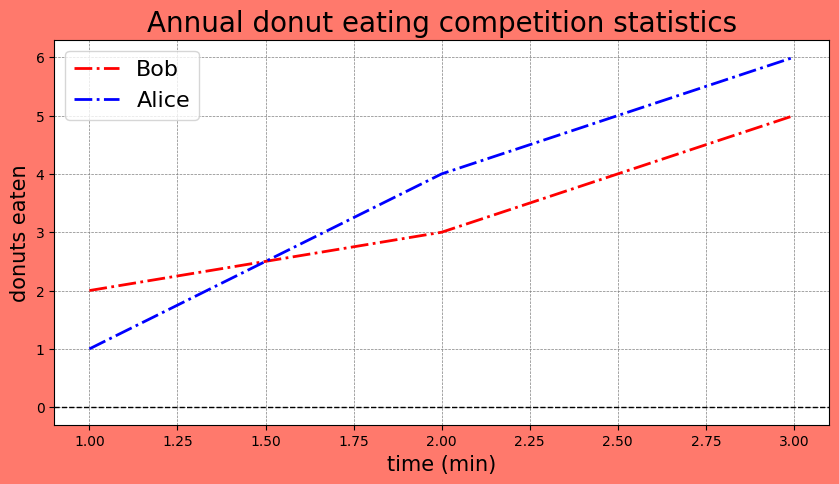

In [3]:
# test
layout = {
    "figsize" : (10, 5),
    "background_color" : "xkcd:salmon",
    "title" : "Annual donut eating competition statistics",
    "x_label" : "time (min)",
    "y_label" : "donuts eaten",
    "grid" : True,
    "line_style" : "-.",
    "line_width" : 2,
    "line_color" : ["red", "blue"],
    "legend_loc" : "upper left",
    "legend_fontsize" : 15,
    "title_fontsize" : 20,
    "axis_label_fontsize" : 15
}

my_smarter_plotter([1, 2, 3], [[2, 3, 5], [1, 4, 6]], layout, names = ["Bob", "Alice"])

# HW 2/2
Upgrade the BSM call option pricer to be able to return the greeks as well, not just the price.

In [4]:
"""The pricing function of European call option"""
"""...with greeks"""
# assuming t = 0?
def black_scholes_eur_call_with_greeks(r: float, T: float, S0: float, sigma: float, K: Union[float, List[float]]):
    """
    Black-Scholes pricer of European call option on non-dividend-paying stock

    param r: risk-free interest rate (which is constant)
    param T: time to maturity (in years)
    param S0: initial spot price of the underlying stock
    param sigma: volatility of the underlying stock
    param K: strike price (or prices)
    """
    
    # check conditions
    assert sigma > 0

    K = np.array([K]) if isinstance(K, float) else np.array(K)

    # fix parameters
    d1_vec = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * T ** 0.5)
    d2_vec = d1_vec - sigma * T ** 0.5

    # distribution functions
    N_d1_vec = norm.cdf(d1_vec)
    N_d2_vec = norm.cdf(d2_vec)
    
    # density functions
    N_der_d1_vec = norm.pdf(d1_vec)
    N_der_d2_vec = norm.pdf(d2_vec)
    
    # PRICE
    # -------
    c = N_d1_vec * S0 - K_vec * np.exp(-r * T) * N_d2_vec
    
    # DELTA
    # -------
    delta = N_d1_vec
    
    # VEGA
    # -------
    Vega = S0 * N_der_d1_vec * np.sqrt(T)
    
    # THETA
    # -------
    Theta = -S0 * N_der_d1_vec * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * N_d2_vec
    
    # RHO
    # -------
    rho = K * T * np.exp(-r * T) * N_d2_vec
    
    # GAMMA
    # -------
    Gamma = N_der_d1_vec / (S0 * sigma * np.sqrt(T))
    
    
    return c, delta, Vega, Theta, rho, Gamma

In [5]:
# look at example from lecture:

# strike prices for which the option price is calculated
K_vec = np.arange(10, 30, 0.01)
# time to maturities (in year fractions)
T_vec = [1.0, 2.0, 5.0]

prices_to_plot = []
deltas_to_plot = []
Vegas_to_plot = []
Thetas_to_plot = []
rhos_to_plot = []
Gammas_to_plot = []
for _T in T_vec:
    # price and derivatives
    BSM_tmp = black_scholes_eur_call_with_greeks(r = 0.05, T = _T, S0 = 20.0, sigma = 0.3, K = K_vec)
    
    prices_to_plot.append(BSM_tmp[0])
    deltas_to_plot.append(BSM_tmp[1])
    Vegas_to_plot.append(BSM_tmp[2])
    Thetas_to_plot.append(BSM_tmp[3])
    rhos_to_plot.append(BSM_tmp[4])
    Gammas_to_plot.append(BSM_tmp[5])

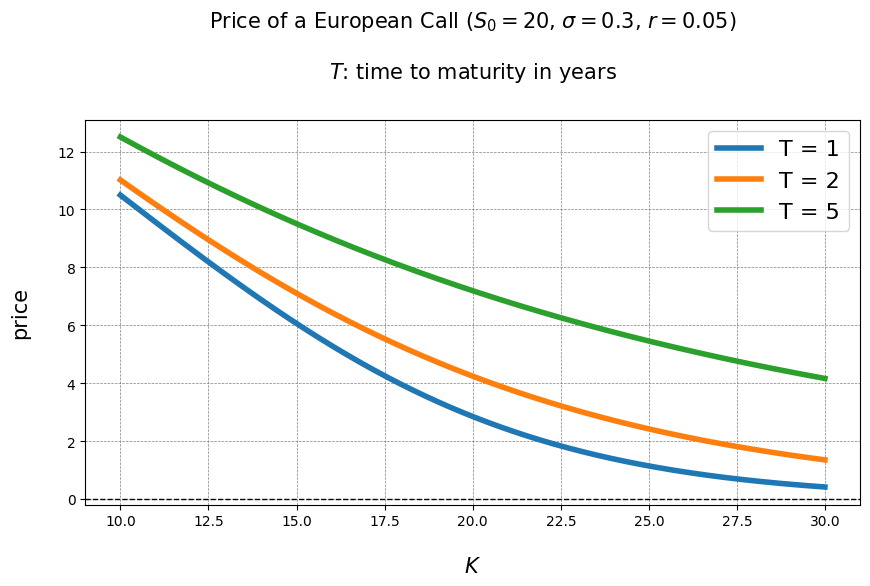

In [6]:
# price
layout_price = {
    "figsize" : (10, 5),
    "title" : "Price of a European Call ($S_0 = 20$, $\sigma = 0.3$, $r = 0.05$)\n\n$T$: time to maturity in years",
    "x_label" : "$K$",
    "y_label" : "price",
    "grid" : True,
    "line_style" : "-",
    "legend_fontsize" : 15,
    "title_fontsize" : 15,
    "axis_label_fontsize" : 15 
}

my_smarter_plotter(K_vec, prices_to_plot, layout = layout_price, names = [f'T = {int(item)}' for item in T_vec])

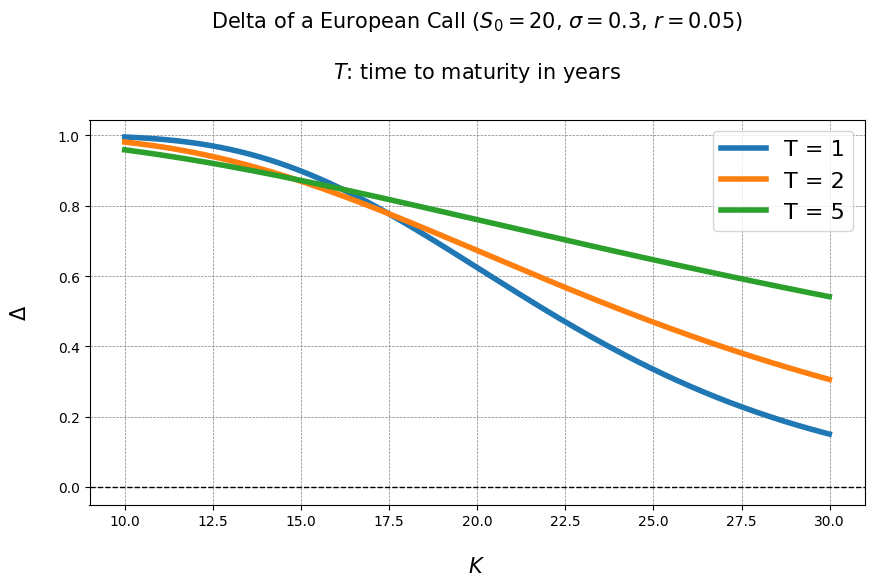

In [7]:
# delta
layout_price = {
    "figsize" : (10, 5),
    "title" : "Delta of a European Call ($S_0 = 20$, $\sigma = 0.3$, $r = 0.05$)\n\n$T$: time to maturity in years",
    "x_label" : "$K$",
    "y_label" : "$\Delta$",
    "grid" : True,
    "line_style" : "-",
    "legend_fontsize" : 15,
    "title_fontsize" : 15,
    "axis_label_fontsize" : 15 
}

my_smarter_plotter(K_vec, deltas_to_plot, layout = layout_price, names = [f'T = {int(item)}' for item in T_vec])

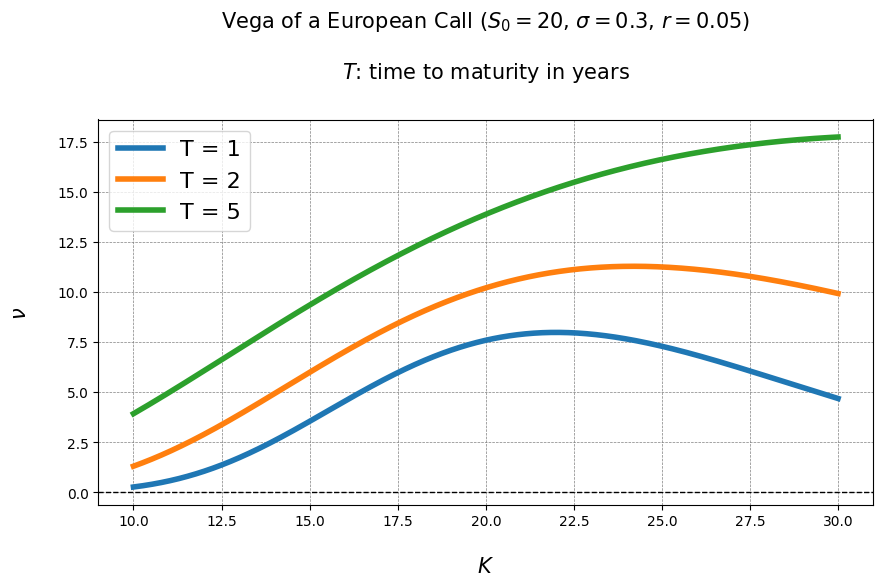

In [8]:
# Vega
layout_price = {
    "figsize" : (10, 5),
    "title" : "Vega of a European Call ($S_0 = 20$, $\sigma = 0.3$, $r = 0.05$)\n\n$T$: time to maturity in years",
    "x_label" : "$K$",
    "y_label" : r"$\nu$",
    "grid" : True,
    "line_style" : "-",
    "legend_fontsize" : 15,
    "title_fontsize" : 15,
    "axis_label_fontsize" : 15 
}

my_smarter_plotter(K_vec, Vegas_to_plot, layout = layout_price, names = [f'T = {int(item)}' for item in T_vec])

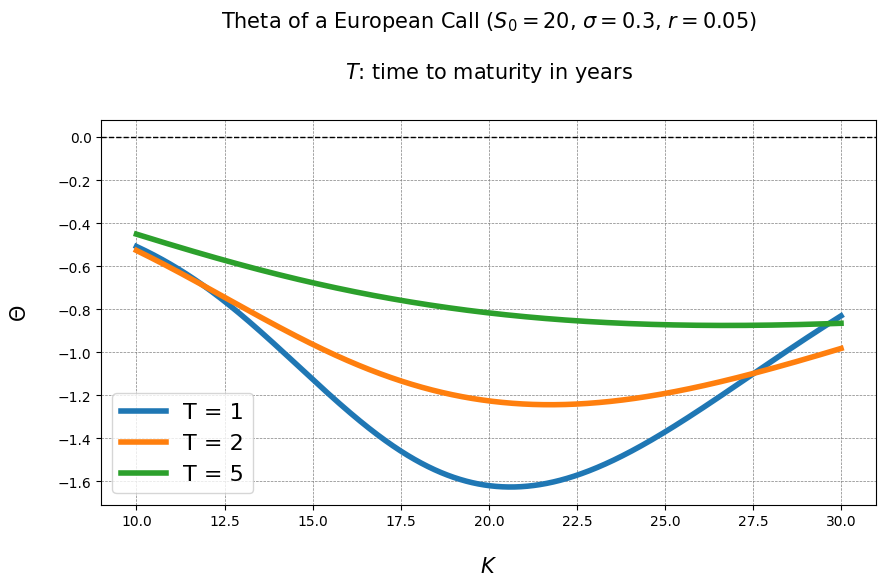

In [9]:
# Theta
layout_price = {
    "figsize" : (10, 5),
    "title" : "Theta of a European Call ($S_0 = 20$, $\sigma = 0.3$, $r = 0.05$)\n\n$T$: time to maturity in years",
    "x_label" : "$K$",
    "y_label" : r"$\Theta$",
    "grid" : True,
    "line_style" : "-",
    "legend_fontsize" : 15,
    "title_fontsize" : 15,
    "axis_label_fontsize" : 15 
}

my_smarter_plotter(K_vec, Thetas_to_plot, layout = layout_price, names = [f'T = {int(item)}' for item in T_vec])

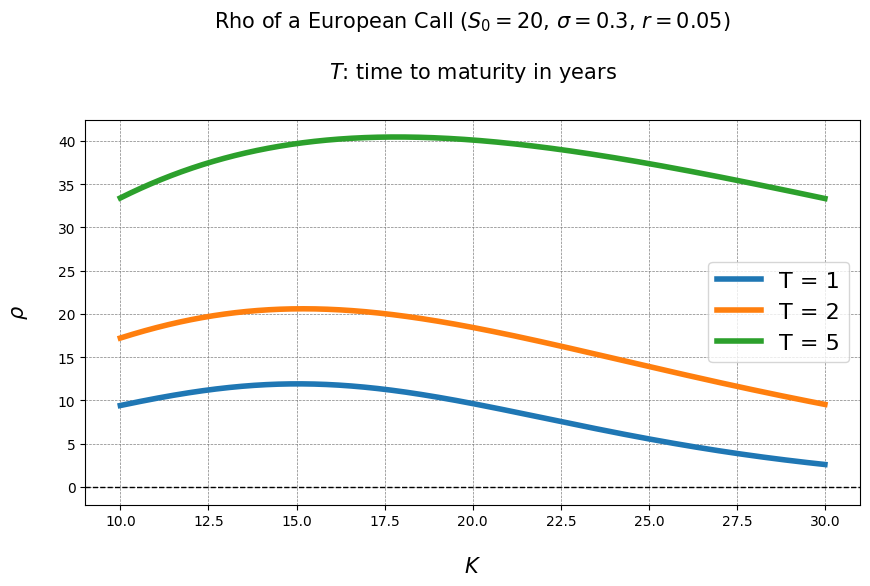

In [10]:
# rho
layout_price = {
    "figsize" : (10, 5),
    "title" : "Rho of a European Call ($S_0 = 20$, $\sigma = 0.3$, $r = 0.05$)\n\n$T$: time to maturity in years",
    "x_label" : "$K$",
    "y_label" : r"$\rho$",
    "grid" : True,
    "line_style" : "-",
    "legend_fontsize" : 15,
    "title_fontsize" : 15,
    "axis_label_fontsize" : 15 
}

my_smarter_plotter(K_vec, rhos_to_plot, layout = layout_price, names = [f'T = {int(item)}' for item in T_vec])

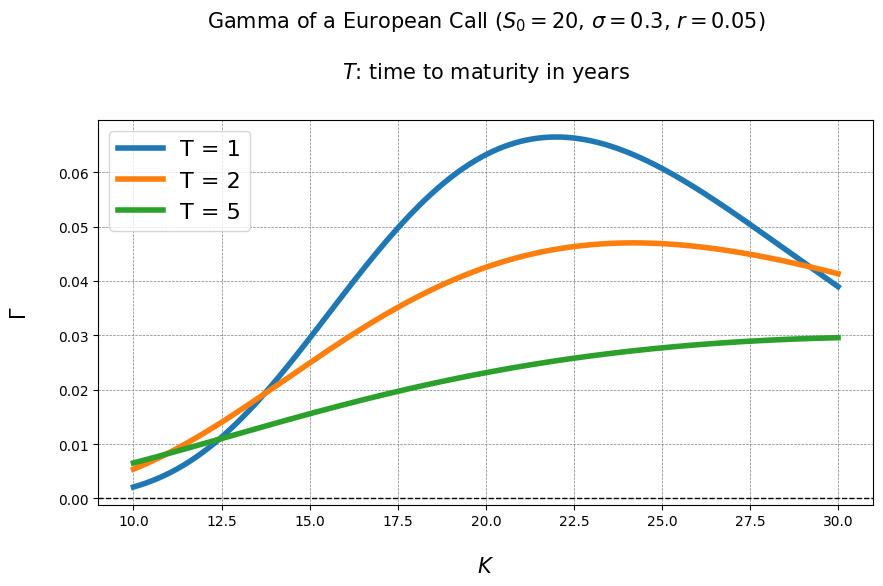

In [11]:
# Gamma
layout_price = {
    "figsize" : (10, 5),
    "title" : "Gamma of a European Call ($S_0 = 20$, $\sigma = 0.3$, $r = 0.05$)\n\n$T$: time to maturity in years",
    "x_label" : "$K$",
    "y_label" : r"$\Gamma$",
    "grid" : True,
    "line_style" : "-",
    "legend_fontsize" : 15,
    "title_fontsize" : 15,
    "axis_label_fontsize" : 15 
}

my_smarter_plotter(K_vec, Gammas_to_plot, layout = layout_price, names = [f'T = {int(item)}' for item in T_vec])

# HW 2/3
Implement the BSM pricer for European put option.

In [12]:
"""The pricing function of European put option"""
# assuming t = 0?
def black_scholes_eur_put(r: float, T: float, S0: float, sigma: float, K: Union[float, List[float]]):
    """
    Black-Scholes pricer of European call option on non-dividend-paying stock

    param r: risk-free interest rate (which is constant)
    param T: time to maturity (in years)
    param S0: initial spot price of the underlying stock
    param sigma: volatility of the underlying stock
    param K: strike price (or prices)
    """
    
    # check conditions
    assert sigma > 0

    K = np.array([K]) if isinstance(K, float) else np.array(K)

    # fix parameters
    d1_vec = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * T ** 0.5)
    d2_vec = d1_vec - sigma * T ** 0.5

    # distribution functions
    N_d1_vec = norm.cdf(-d1_vec)
    N_d2_vec = norm.cdf(-d2_vec)
     
    # according to Wikipedia:
    # PRICE
    # -------
    c = -N_d1_vec * S0 + K_vec * np.exp(-r * T) * N_d2_vec    
    
    return c

# HW 2/4
With the call and put pricer, check if Put-Call parity holds in practice.

In [13]:
# calculate put prices with the same parameters what we had for call
prices_to_plot_put = []
# difference of call and put price based on put-call parity
parity_RHS = []
for _T in T_vec:
    # price and derivatives
    BSM_tmp = black_scholes_eur_put(r = 0.05, T = _T, S0 = 20.0, sigma = 0.3, K = K_vec)
    prices_to_plot_put.append(BSM_tmp)
    parity_RHS.append(20 - K_vec * np.exp(-0.05 * _T))

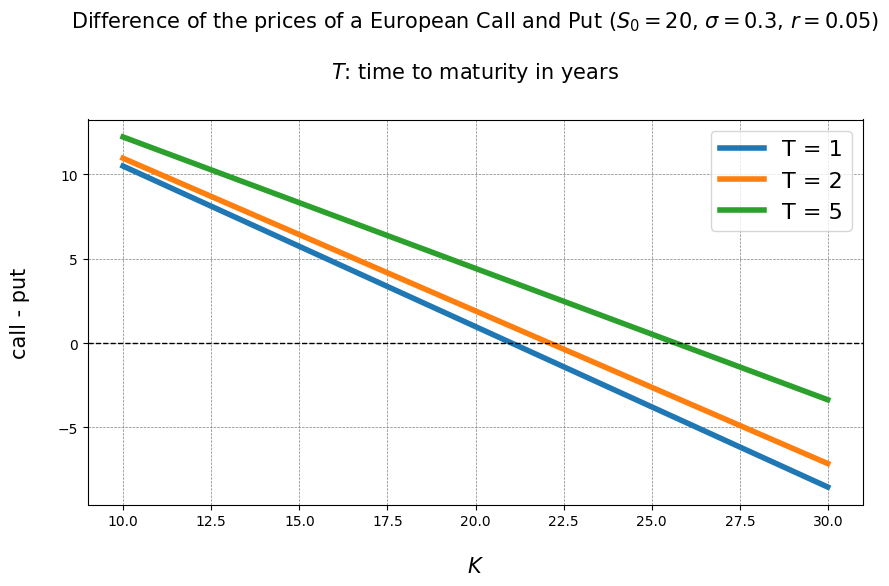

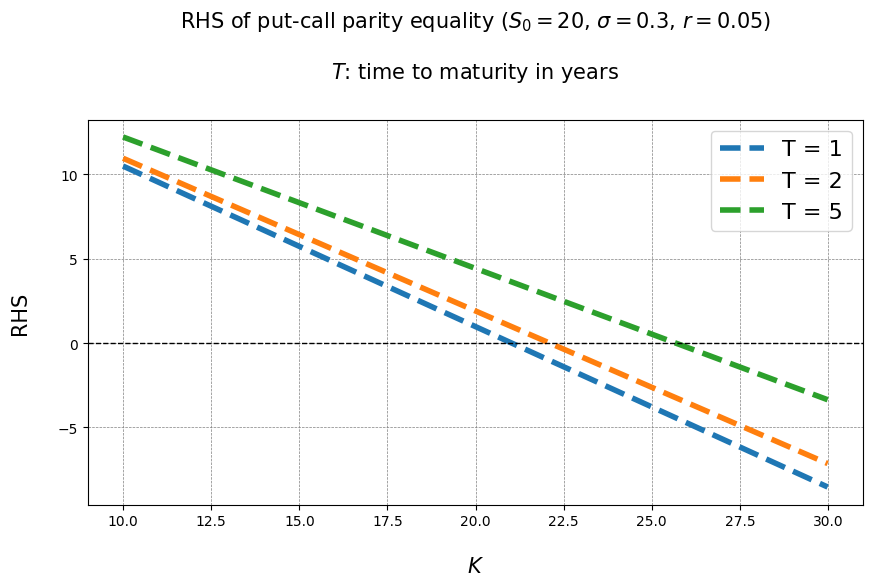

In [14]:
# check put-call parity

# price
layout_cp = {
    "figsize" : (10, 5),
    "title" : "Difference of the prices of a European Call and Put ($S_0 = 20$, $\sigma = 0.3$, $r = 0.05$)\n\n$T$: time to maturity in years",
    "x_label" : "$K$",
    "y_label" : "call - put",
    "grid" : True,
    "line_style" : "-",
    "legend_fontsize" : 15,
    "title_fontsize" : 15,
    "axis_label_fontsize" : 15 
}

layout_cp_RHS = {
    "figsize" : (10, 5),
    "title" : "RHS of put-call parity equality ($S_0 = 20$, $\sigma = 0.3$, $r = 0.05$)\n\n$T$: time to maturity in years",
    "x_label" : "$K$",
    "y_label": "RHS",
    "grid" : True,
    "line_style" : "--",
    "legend_fontsize" : 15,
    "title_fontsize" : 15,
    "axis_label_fontsize" : 15 
}

# difference in call and price
difference_c_p = list(np.array(prices_to_plot) - np.array(prices_to_plot_put))

my_smarter_plotter(K_vec, difference_c_p, layout = layout_cp, names = [f'T = {int(item)}' for item in T_vec])
my_smarter_plotter(K_vec, parity_RHS, layout = layout_cp_RHS, names = [f'T = {int(item)}' for item in T_vec])